# Anomaly Detection for Dummies
[https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1](https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1)

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [4]:
df = pd.read_csv('data/Sample_Superstore.csv.gz', compression='gzip')
df_original = df.copy()
df.shape

(9994, 22)

## Univariate Anomaly Detection

### Distribution of the Sales

In [5]:
df['Sales'].describe()

count     9994.000000
mean       229.858001
std        623.245101
min          0.444000
25%         17.280000
50%         54.490000
75%        209.940000
max      22638.480000
Name: Sales, dtype: float64

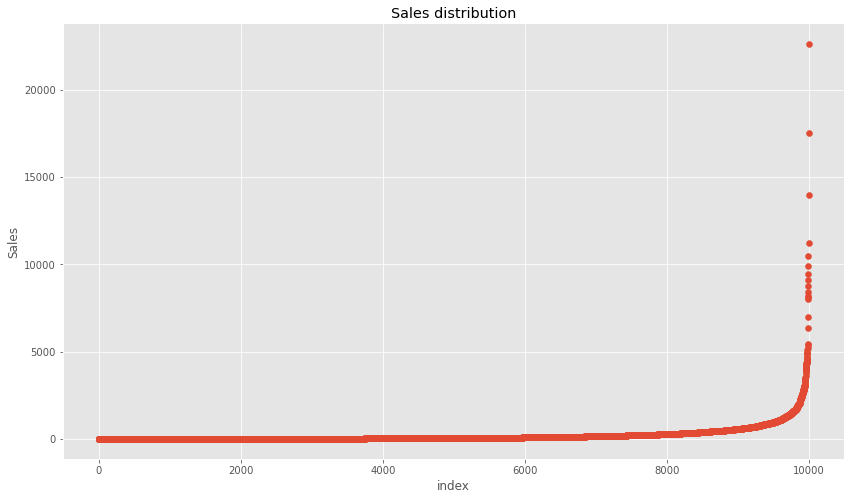

In [6]:
plt.scatter(range(df.shape[0]), np.sort(df['Sales'].values))
plt.xlabel('index')
plt.ylabel('Sales')
plt.title("Sales distribution")
sns.despine()

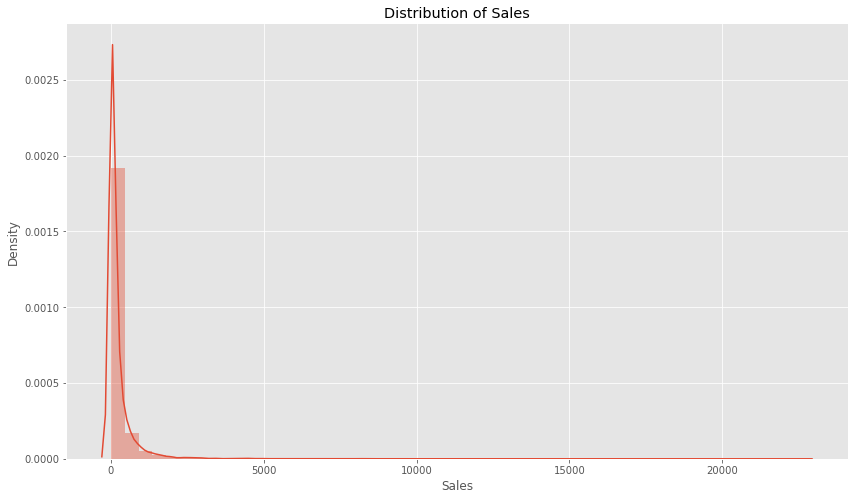

In [7]:
sns.distplot(df['Sales'])
plt.title("Distribution of Sales")
sns.despine()

There is one region where the data has low probability to appear which is on the right side of the distribution.

In [8]:
print("'Sales' Skewness: %f" % df['Sales'].skew())
print("'Sales' Kurtosis: %f" % df['Sales'].kurt())

'Sales' Skewness: 12.972752
'Sales' Kurtosis: 305.311753


### Distribution of the Profit

In [9]:
df['Profit'].describe()

count    9994.000000
mean       28.656896
std       234.260108
min     -6599.978000
25%         1.728750
50%         8.666500
75%        29.364000
max      8399.976000
Name: Profit, dtype: float64

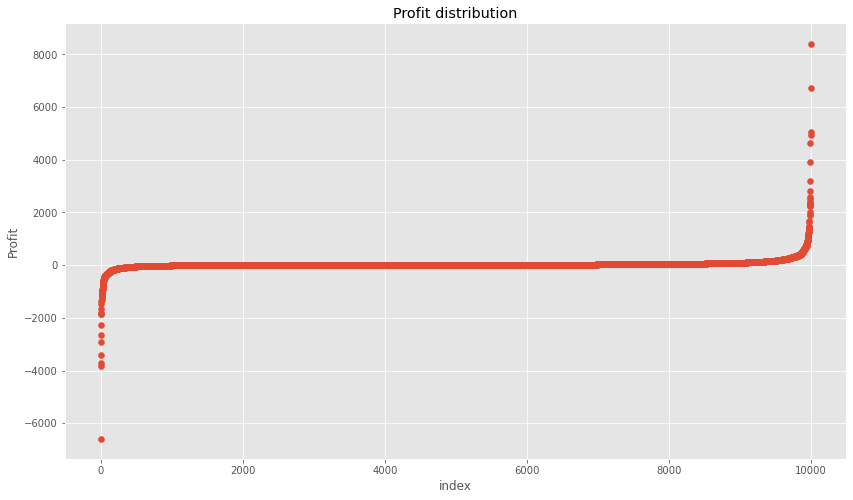

In [10]:
plt.scatter(range(df.shape[0]), np.sort(df['Profit'].values))
plt.xlabel('index')
plt.ylabel('Profit')
plt.title("Profit distribution")
sns.despine()

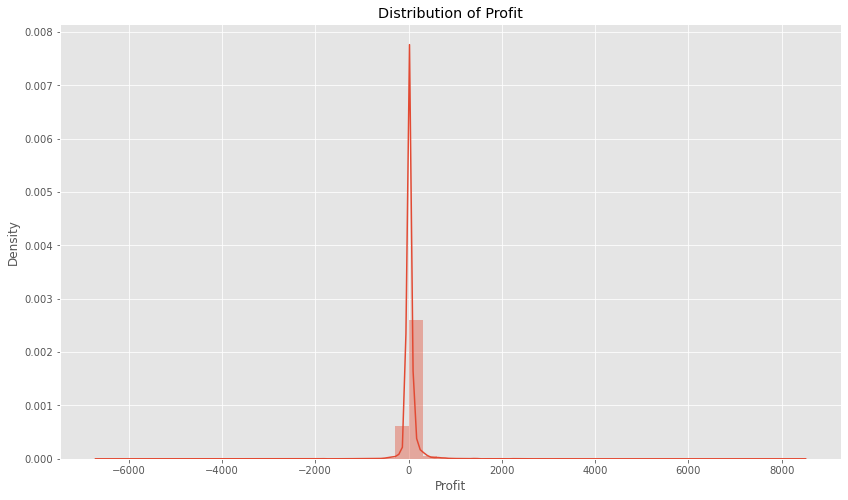

In [11]:
sns.distplot(df['Profit'])
plt.title('Distribution of Profit')
plt.show()

There are two regions where the data has low probability to appear: one on the right side of the distribution, another one on the left.

In [12]:
print("'Profit' Skewness: %f" % df['Profit'].skew())
print("'Profit' Kurtosis: %f" % df['Profit'].kurt())

'Profit' Skewness: 7.561432
'Profit' Kurtosis: 397.188515


### Univariate Anomaly Detection on Sales

In [13]:
isolation_forest = IsolationForest(random_state=123)
isolation_forest.fit(df['Sales'].values.reshape(-1, 1))
xx = np.linspace(df['Sales'].min(), df['Sales'].max(), num=len(df)).reshape(-1, 1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

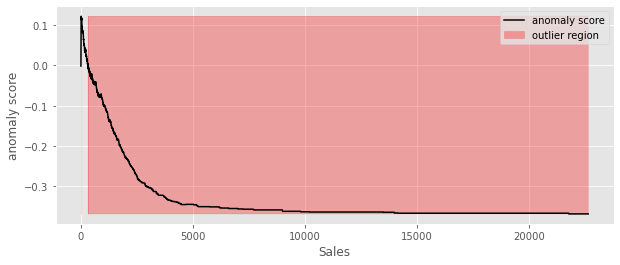

In [14]:
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, color='k', label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=(outlier==-1), color='r', 
                 alpha=.3, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Sales')
plt.show();

### Univariate Anomaly Detection on Profit

In [15]:
isolation_forest = IsolationForest(random_state=123)
isolation_forest.fit(df['Profit'].values.reshape(-1, 1))
xx = np.linspace(df['Profit'].min(), df['Profit'].max(), len(df)).reshape(-1, 1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

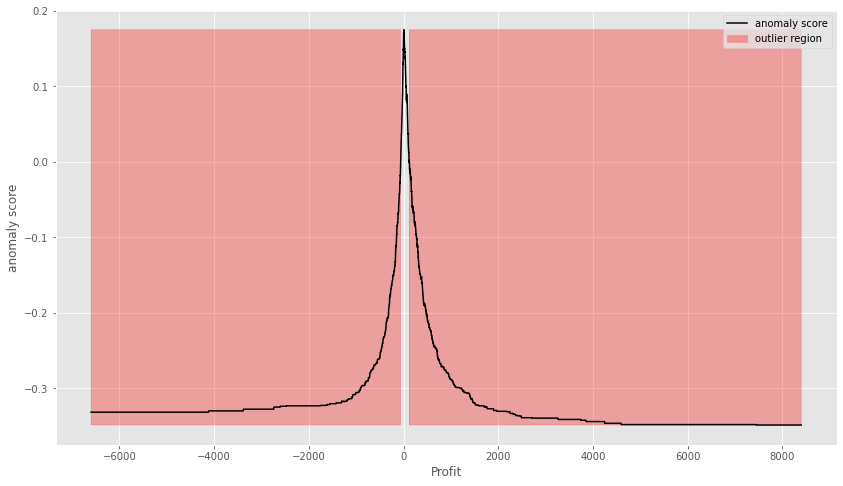

In [16]:
plt.plot(xx, anomaly_score, color='k', label='anomaly score')
plt.fill_between(xx.T[0], anomaly_score.min(), anomaly_score.max(), 
                 where=(outlier==-1), color='r', 
                 alpha=0.3, label='outlier region')

plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Profit')
plt.show()

## Multivariate Anomaly Detection

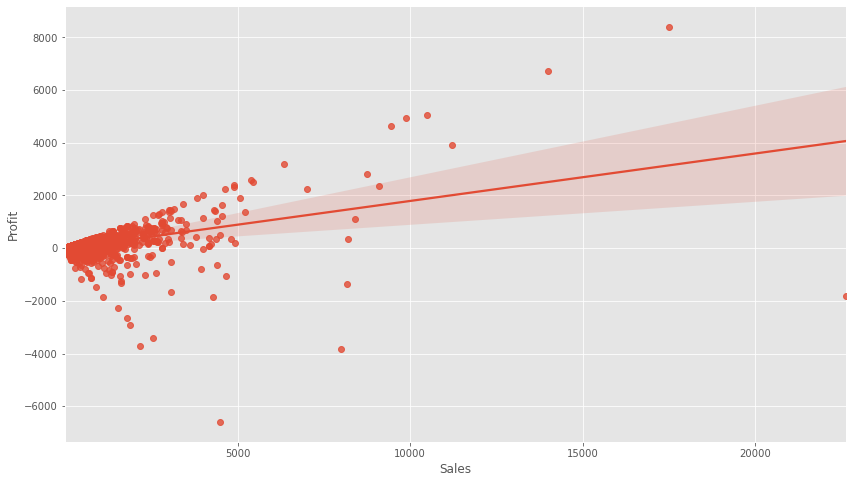

In [17]:
sns.regplot(x='Sales', y='Profit', data=df)
sns.despine()

### Cluster-based Local Outlier Factor (CBLOF)

In [18]:
sc = MinMaxScaler(feature_range=(0, 1))
df[['Sales', 'Profit']] = sc.fit_transform(df[['Sales', 'Profit']])
X = df[['Sales', 'Profit']].copy()

In [19]:
outliers_fraction = 0.01
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))

In [20]:
clf = CBLOF(contamination=outliers_fraction, 
            check_estimator=False, 
            random_state=0)
clf.fit(X)
scores_pred = clf.decision_function(X) * -1
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)

n_inliers, n_outliers

(9894, 100)

In [21]:
df1 = df.copy()
df1['outlier'] = y_pred.tolist()

In [22]:
# inliers
inliers_sales = df1[df1['outlier'] == 0]['Sales'].values.reshape(-1, 1)
inliers_profit = df1[df1['outlier'] == 0]['Profit'].values.reshape(-1, 1)

# outliers
outliers_sales = df1[df1['outlier'] == 1]['Sales'].values.reshape(-1, 1)
outliers_profit = df1[df1['outlier'] == 1]['Profit'].values.reshape(-1, 1)

# Use threshold value to consider a datapoint inlier or outlier
# threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
threshold = np.percentile(scores_pred, 100 * outliers_fraction)

In [23]:
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

OUTLIERS: 100,  INLIERS: 9894


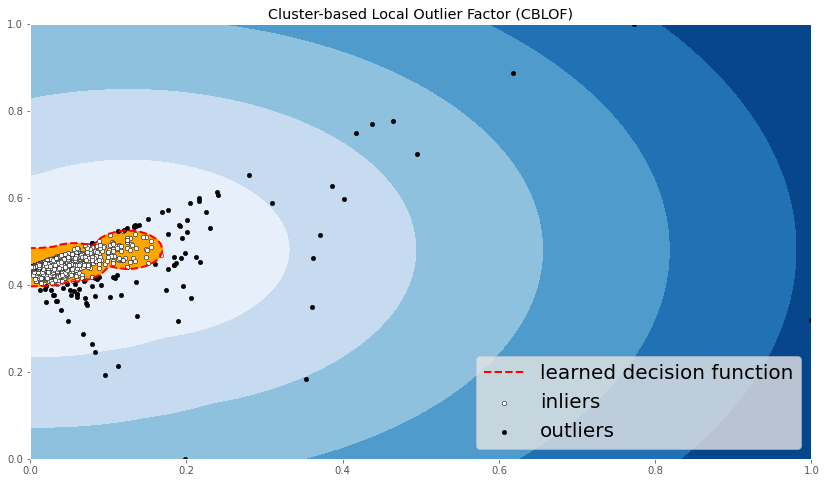

In [24]:
print(f'OUTLIERS: {n_outliers},  INLIERS: {n_inliers}')

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Cluster-based Local Outlier Factor (CBLOF)')
plt.show();

In [25]:
df_original[['Sales', 'Quantity', 'Discount', 'Profit']][df1['outlier'] == 1].sample(n=5)

,Sales,Quantity,Discount,Profit
4860,1793.980,2,0.0,843.1706
2846,762.594,3,0.8,-1143.8910
2492,4548.810,7,0.0,1228.1787
509,6354.950,5,0.0,3177.4750
5066,1781.682,7,0.4,-653.2834


### Histogram-based Outlier Detection (HBOS)

In [26]:
clf_hist = HBOS(contamination=outliers_fraction)
clf_hist.fit(X)
scores_pred_hist = clf_hist.decision_function(X) * -1
y_pred_hist = clf_hist.predict(X)

n_inliers_hist = np.sum(y_pred_hist == 0)
n_outliers_hist = np.sum(y_pred_hist == 1)

In [27]:
df2 = df.copy()
df2['outlier'] = y_pred_hist.tolist()

# inliers
inliers_sales_hist = df2[df2['outlier'] == 0]['Sales'].values.reshape(-1, 1)
inliers_profit_hist = df2[df2['outlier'] == 0]['Profit'].values.reshape(-1, 1)
# outlier
outliers_sales_hist = df2[df2['outlier'] == 1]['Sales'].values.reshape(-1, 1)
outliers_profit_hist = df2[df2['outlier'] == 1]['Profit'].values.reshape(-1, 1)


threshold_hist = np.percentile(scores_pred_hist, 100 * outliers_fraction)
Z = clf_hist.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

OUTLIERS: 90,  INLIERS: 9904


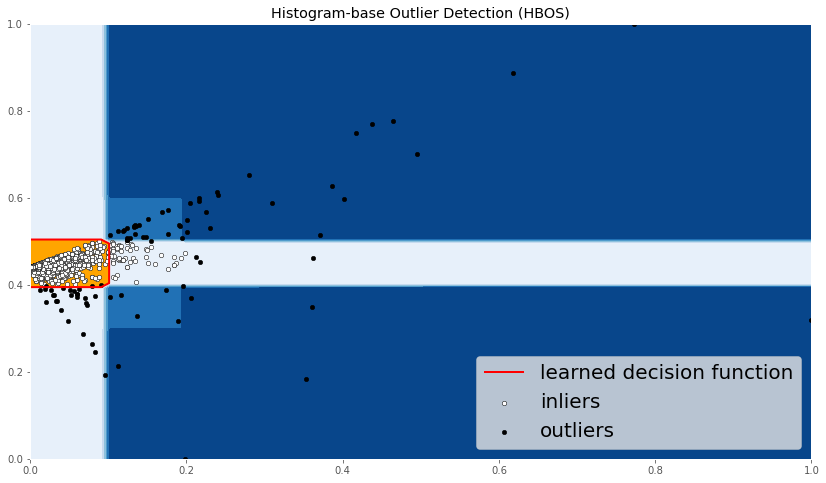

In [28]:
print(f'OUTLIERS: {n_outliers_hist},  INLIERS: {n_inliers_hist}')
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold_hist, 7),cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[threshold_hist],linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold_hist, Z.max()],colors='orange')
b = plt.scatter(inliers_sales_hist, inliers_profit_hist, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales_hist, outliers_profit_hist, c='black',s=20, edgecolor='k')
       
plt.axis('tight')      
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Histogram-base Outlier Detection (HBOS)')
plt.show();

In [29]:
df_original[['Sales', 'Quantity', 'Discount', 'Profit']][df2['outlier'] == 1].sample(n=5)

,Sales,Quantity,Discount,Profit
7772,4499.985,5,0.7,-6599.9780
8488,8749.950,5,0.0,2799.9840
8208,1369.764,6,0.7,-913.1760
4128,2624.985,3,0.5,-944.9946
9741,4404.900,5,0.0,1013.1270


### Isolation Forest

In [30]:
clf_iso = IForest(contamination=outliers_fraction, random_state=0)
clf_iso.fit(X)
scores_pred_iso = clf_iso.decision_function(X) * -1
y_pred_iso = clf_iso.predict(X)

In [31]:
n_inliers_iso = np.sum(y_pred_iso == 0)
n_outliers_iso = np.sum(y_pred_iso == 1)

df3 = df.copy()
df3['outlier'] = y_pred_iso.tolist()
# inliers
inliers_sales_iso = df3[df3['outlier'] == 0]['Sales'].values.reshape(-1, 1)
inliers_profit_iso = df3[df3['outlier'] == 0]['Profit'].values.reshape(-1, 1)

# outliers
outliers_sales_iso = df3[df3['outlier'] == 1]['Sales'].values.reshape(-1, 1)
outliers_profit_iso = df3[df3['outlier'] == 1]['Profit'].values.reshape(-1, 1)

In [32]:
threshold_iso = np.percentile(scores_pred_iso, 100 * outliers_fraction)
Z = clf_iso.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

OUTLIERS: 100,  INLIERS: 9894


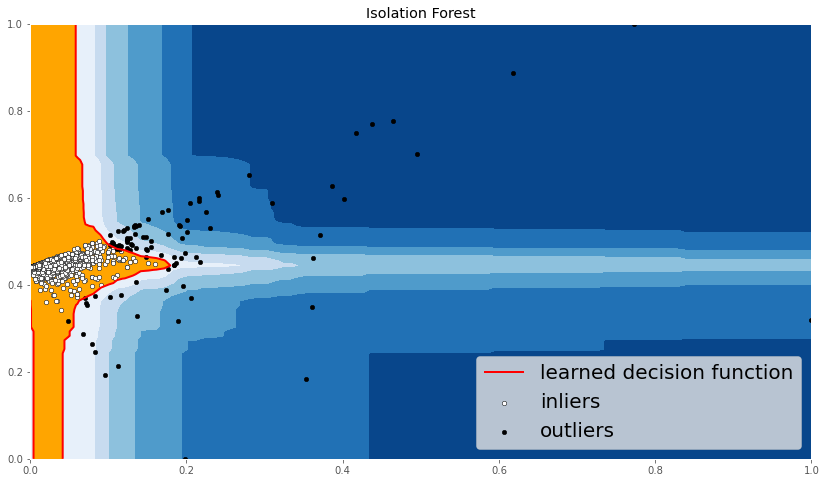

In [33]:
print(f'OUTLIERS: {n_outliers_iso},  INLIERS: {n_inliers_iso}')

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold_iso, 7),cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[threshold_iso],linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold_iso, Z.max()],colors='orange')
b = plt.scatter(inliers_sales_iso, inliers_profit_iso, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales_iso, outliers_profit_iso, c='black',s=20, edgecolor='k')
       
plt.axis('tight')
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Isolation Forest')
plt.show();

In [34]:
df_original[['Sales', 'Quantity', 'Discount', 'Profit']][df3['outlier'] == 1].sample(n=5)

,Sales,Quantity,Discount,Profit
7666,5399.910,9,0.0,2591.9568
1001,2309.650,7,0.0,762.1845
4297,4367.896,13,0.2,327.5922
3011,2549.985,5,0.7,-3399.9800
683,7999.980,4,0.5,-3839.9904


### K - Nearest Neighbors (KNN)

In [35]:
clf_knn = KNN(contamination=outliers_fraction)
clf_knn.fit(X)
scores_pred_knn = clf_knn.decision_function(X) * -1
y_pred_knn = clf_knn.predict(X)

In [36]:
n_inliers_knn = np.sum(y_pred_knn == 0)
n_outliers_knn = np.sum(y_pred_knn == 1)

df4 = df.copy()
df4['outlier'] = y_pred_knn.tolist()

# inliers
inliers_sales_knn = df4[df4['outlier'] == 0]['Sales'].values.reshape(-1, 1)
inliers_profit_knn = df4[df4['outlier'] == 0]['Profit'].values.reshape(-1, 1)

# outliers
outliers_sales_knn = df4[df4['outlier'] == 1]['Sales'].values.reshape(-1, 1)
outliers_profit_knn = df4[df4['outlier'] == 1]['Profit'].values.reshape(-1, 1)

In [37]:
threshold_knn = np.percentile(scores_pred_knn, 100 * outliers_fraction)
Z = clf_knn.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

OUTLIERS: 91,  INLIERS: 9903


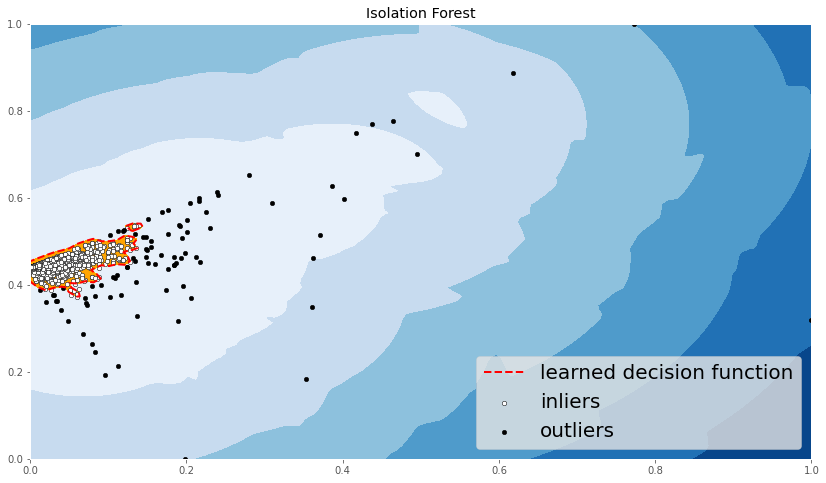

In [38]:
print(f'OUTLIERS: {n_outliers_knn},  INLIERS: {n_inliers_knn}')

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold_knn, 7),cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[threshold_knn],linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold_knn, Z.max()],colors='orange')
b = plt.scatter(inliers_sales_knn, inliers_profit_knn, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales_knn, outliers_profit_knn, c='black',s=20, edgecolor='k')
       
plt.axis('tight')
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Isolation Forest')
plt.show();

In [39]:
df_original[['Sales', 'Quantity', 'Discount', 'Profit']][df4['outlier'] == 1].sample(n=5)

,Sales,Quantity,Discount,Profit
7583,3499.930,7,0.0,909.9818
1199,1088.792,4,0.8,-1850.9464
4297,4367.896,13,0.2,327.5922
262,3059.982,3,0.4,-509.9970
9425,3785.292,6,0.1,420.5880
